In [42]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import cv2
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

std_size = (7, 4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Comparison of PCA, PCAAE, OneH and TempConv reconstruction errors when encoding 30 sec of gray scale 256x256 video (R25_gray_scaled.mp4)

In [25]:
video_filename = 'data/R25_gray_scaled.mp4'

def train_helper(model_key, base_model, model_args, video, lrs, models, num_epoch_tune=10, num_epoch=50):
    iteration_per_epoch = int(video.duration_frames/video.batch_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device', device)
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))

    losses_tune = []
    for lr in lrs:
        if len(lrs) == 1:
            losses_tune.append(0)
            break
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = base_model(*model_args).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(num_epoch_tune):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        losses_tune.append(epoch_loss / iteration_per_epoch)
        if len(losses_tune) >= 2 and losses_tune[-1] > losses_tune[-2]:
            break
    lr = lrs[np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = base_model(*model_args).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            reconstructed = model(frames)
            loss = crit(frames, reconstructed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / iteration_per_epoch)
        if (epoch+1) % 3 == 0:
            print(f'\t Error at epoch {epoch+1}:', losses[-1])

    model_dict = {
        'model': model.state_dict(),
        'epoch': num_epoch,
        'optimizer': optimizer.state_dict(),
        'lr': lr,
        'losses_tune': losses_tune,
        'lrs': lrs,
        'losses': losses,
        'epoch_time': (time()-t1)/num_epoch
    }
    models[model_key] = model_dict
    return model

def evaluate_model(model, model_key, models, meta):
    reconstructed_train = video_train.reduce_latent(model, trans=False)
    reconstructed_test = video_test.reduce_latent(model, trans=False)
    original_frames_train_ = original_frames_train.numpy().reshape(-1, *video_train.sample_shape)
    original_frames_test_  = original_frames_test.numpy().reshape(-1, *video_test.sample_shape)
    models[key]['train_error'] = reconstruction_error(original_frames_train_, reconstructed_train.numpy())
    models[key]['test_error'] = reconstruction_error(original_frames_test_, reconstructed_test.numpy())
    print('Training error:', models[key]['train_error'])
    print('Testing error:', models[key]['test_error'])
    reconstructed_train_ = reconstructed_train.numpy().reshape(-1, video_train.height, video_train.width)

video_train = VideoLoader(video_filename, duration=30, gray=True)
video_test =  VideoLoader(video_filename, start=30, duration=10, gray=True)
meta = {'w': video_train.width,
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
original_frames_train = video_train.get_all_frames()
original_frames_test = video_test.get_all_frames()
num_epoch, num_epoch_tune = 40, 10
models = {}

In [26]:
############   PCA autoencoder   ############
lrs = [1e-05, 5e-05, 1e-04]
key = '50-PCAAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, meta['h'], meta['w'])
all_frames = video_train.get_all_frames()
mean, std = torch.mean(all_frames), torch.std(all_frames)
model = train_helper(key, PCAAutoEncoder, ((1, meta['w'], meta['h']), 50, mean, std), video_train,
                           lrs, models, num_epoch_tune=15)
model.to(torch.device('cpu'))
evaluate_model(model, key, models, meta)

############ One hidden layer AE ############
key = '10-OneHAE'
print('\nModel', key)
lrs = np.logspace(-5, -4, num=6)
video_train.sample_shape = video_test.sample_shape = (1, meta['h'], meta['w'])
model = train_helper(key, OneHAutoEncoder, ((1, meta['h'], meta['w']), 10), video_train,
                          lrs, models)
model.to(torch.device('cpu'))
evaluate_model(model, key, models, meta)

############   Temporal Conv AE   ############
key = 'TempConvAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, 16, meta['h'], meta['w'])
model = train_helper(key, TemporalConvAE, (1, 2, 32), video_train, lrs, models)
model.to(torch.device('cpu'))
evaluate_model(model, key, models, meta)

############  10-Temporal Conv AE  ############
key = '10-TempConvAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, 16, meta['h'], meta['w'])
model = train_helper(key, TemporalConvAE, (1, 2, 32, 10), video_train,
                                   lrs, models)
model.to(torch.device('cpu'))
evaluate_model(model, key, models, meta)
torch.save(models, 'data_generated/models_pca(ae)_oneh_tempconv_reconstruction_error_comparison.pth')
discard_keys = ['model', 'optimizer']
models_data = {k: {kv: vv for kv, vv in v.items() if kv not in  discard_keys} for k, v in models.items()}
pickle.dump(models_data,
            open('data_generated/report_figures/models_pca(ae)_oneh_tempconv_reconstruction_error_comparison.pkl', 'wb'))


Model 50-PCAAE
Using device cuda
Tesla P100-PCIE-16GB
Chosen learning rate: 1e-05
	 Error at epoch 3: 59.59207509358724
	 Error at epoch 6: 59.481032307942705
	 Error at epoch 9: 59.532186889648436
	 Error at epoch 12: 59.69335962931315
	 Error at epoch 15: 59.566393025716145
	 Error at epoch 18: 59.57182947794596
	 Error at epoch 21: 59.65827941894531
	 Error at epoch 24: 58.81484578450521
	 Error at epoch 27: 58.69847742716471
	 Error at epoch 30: 57.89087855021159
	 Error at epoch 33: 57.37376251220703
	 Error at epoch 36: 57.867767588297525
	 Error at epoch 39: 58.25819447835286
	 Error at epoch 42: 57.44232177734375
	 Error at epoch 45: 54.89898122151693
	 Error at epoch 48: 54.456031799316406
Training error: 55.18244
Testing error: 56.102825

Model 10-OneHAE
Using device cuda
Tesla P100-PCIE-16GB
Chosen learning rate: 0.0001
	 Error at epoch 3: 118.89419962565104
	 Error at epoch 6: 114.07646077473959
	 Error at epoch 9: 111.58136749267578
	 Error at epoch 12: 110.62248077392579

In [75]:
models_data = pickle.load(open('data_generated/report_figures/models_pca(ae)_oneh_tempconv_reconstruction_error_comparison.pkl', 'rb'))
losses = [m['losses'] for m in models_data.values()]
max_epoch = max([m['epoch'] for m in models_data.values()])
losses.append([8.126883]*max_epoch)
xs = [range(1, m['epoch']+1) for m in models_data.values()] + [range(1, max_epoch+1)]
labels = [l for l in models_data.keys()] + ['10-PCA']

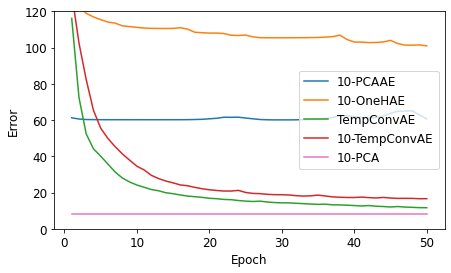

In [76]:
plot(xs, losses, labels=labels,
    xlabel='Epoch', ylabel='Error', yrange=(0, 120), figsize=std_size)
plt.legend()
plt.savefig('data_generated/report_figures/reconstruction_error_comparison_pca_oneh_tempconv.png')

### TempConv, latent dimension comparison. Computed in week5 (testing_colab.ipynb). Use 10 seconds of R25_gray_scaled.mp4 video scaled to 256x256

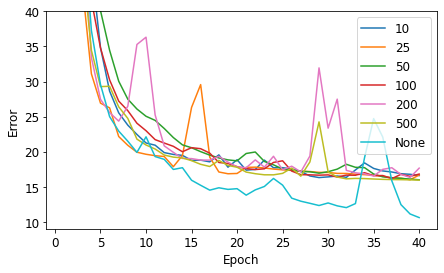

In [77]:
with open('data_generated/all_losses_from_colab_week5.json', 'r') as fp:
    all_losses = json.load(fp)

ys = [l for _, l in all_losses.values()]
labels = [l for l in all_losses.keys()]

plot(range(1, 41), ys, labels=labels, yrange=(9, 40),
     xlabel='Epoch', ylabel='Error', figsize=std_size)
plt.legend(loc='upper right')
plt.savefig('data_generated/report_figures/latent_dimension_comparison_tempconv.png')

### TempConv, depth and number of channels comparison

In [58]:
num_epoch = 50

In [ ]:
video_filename = 'data/R25_gray_scaled.mp4'
video = VideoLoader(video_filename, duration=10, gray=True, randit=True)
num_epoch_tune = 10
iteration_per_epoch = int(video.duration_frames/video.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

all_losses = {}
lrs = {1: [1e-4, 5e-4, 0.001, 0.005],
       2: [1e-4, 5e-4, 0.001],
       3: [1e-4, 5e-4, 0.001],
       4: [1e-5, 5e-5, 1e-4, 5e-4],
       5: [1e-5, 5e-5, 1e-4, 5e-4]}
for nlayers in range(1, 6):
    for layerchans in [4, 8, 12, 32, 64]:
        total_time_start = time()
        print(f'Model with {nlayers} layer with {layerchans} channels:')

        losses_tune = []
        for lr in lrs[nlayers]:
            torch.manual_seed(seed)
            np.random.seed(seed)
            model = TemporalConvAE_week5(1, nlayers, layerchans).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            for epoch in range(num_epoch_tune):
                epoch_loss = 0
                for frames in video:
                    frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
                    reconstructed = model(frames)
                    loss = crit(frames, reconstructed)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
            losses_tune.append(epoch_loss / iteration_per_epoch)
        lr = lrs[nlayers][np.argmin(losses_tune)]
        print('Chosen learning rate:', lr)
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = TemporalConvAE_week5(1, nlayers, layerchans).to(device)
        optimizer = Adam(model.parameters(), lr=lr)

        t1 = time()
        losses = []
        for epoch in range(num_epoch):
            epoch_loss = 0
            for frames in video:
                frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            losses.append(epoch_loss / iteration_per_epoch)
            if (epoch+1) % 3 == 0:
                print(f'\t Error at epoch {epoch+1}:', losses[-1])
        all_losses[f'{nlayers},{layerchans}'] = ((time()-t1)/num_epoch, losses)
        print('Latent dimension:', model.latent_dim)
        print('Total time for model:', sec2string(time()-total_time_start))
all_losses = dict(sorted(all_losses.items()))
all_losses = {f'{l},{c}': all_losses[f'{l},{c}'] for l in [1,2,3,4,5] for c in [4,8,12,32,64]}

pickle.dump(all_losses, open('data_generated/report_figures/all_losses_depth_channels_reconstruction_comparison.pkl', 'wb'))

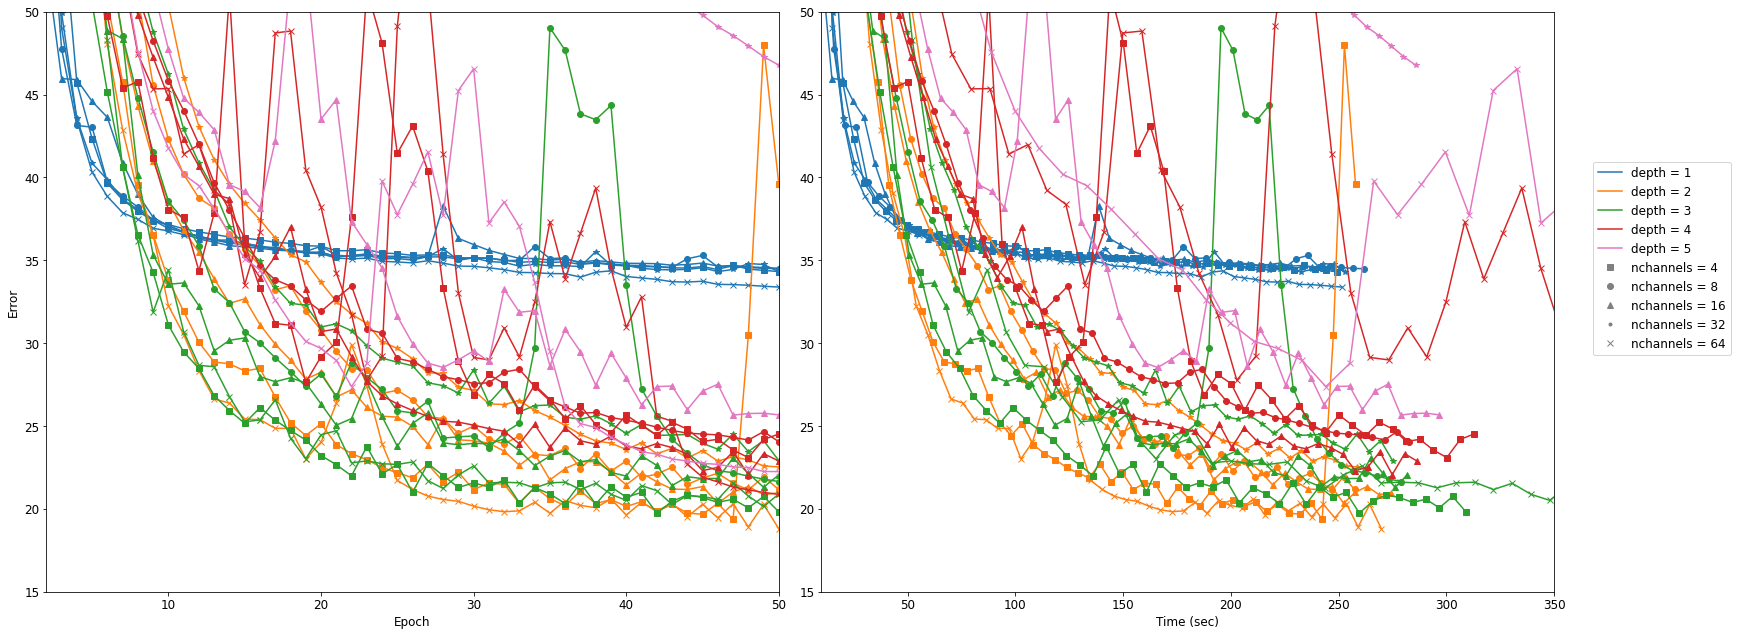

In [87]:
from matplotlib.lines import Line2D

all_losses = pickle.load(open('data_generated/report_figures/all_losses_depth_channels_reconstruction_comparison.pkl', 'rb'))

fig, axs = plt.subplots(1, 2, figsize=(22, 9))
style = ['C'+str(c)+'-'+s for c in [0,1,2,3,6] for s in ['s','o','^','.','']]
[axs[i].set_ylim(15, 50) for i in [0,1]]
axs[0].set_xlim(2, num_epoch)
axs[1].set_xlim(10, 350)

ys = [t[1] for t in all_losses.values()]
for y, s in zip(ys, styles):
    axs[0].plot(np.arange(1, num_epoch+1), y, s)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Error')
    
times = [t for t, _ in all_losses.values()]
xs = np.repeat(np.arange(1, num_epoch+1)[np.newaxis,:], len(ys), axis=0) * np.array(times)[:,np.newaxis]
for x, y, s in zip(xs, ys, styles):
    axs[1].plot(x, y,s)
axs[1].set_xlabel('Time (sec)')

lines_color  = [Line2D([0], [0], linestyle='-', color='C'+str(c)) for c in [0,1,2,3,6]]
lines_marker = [Line2D([0], [0], linewidth=0, marker=s, color='gray') for s in ['s','o','^','.','x']]
labels = ['depth = '+str(i) for i in range(1,6)] + ['nchannels = '+str(i) for i in [4,8,16,32,64]]
fig.legend(lines_color+lines_marker, labels, bbox_to_anchor=(1.1, 0.75))
plt.tight_layout()
plt.savefig('data_generated/report_figures/reconstruction_error_comparison_tempconv_channels_depth.png', )

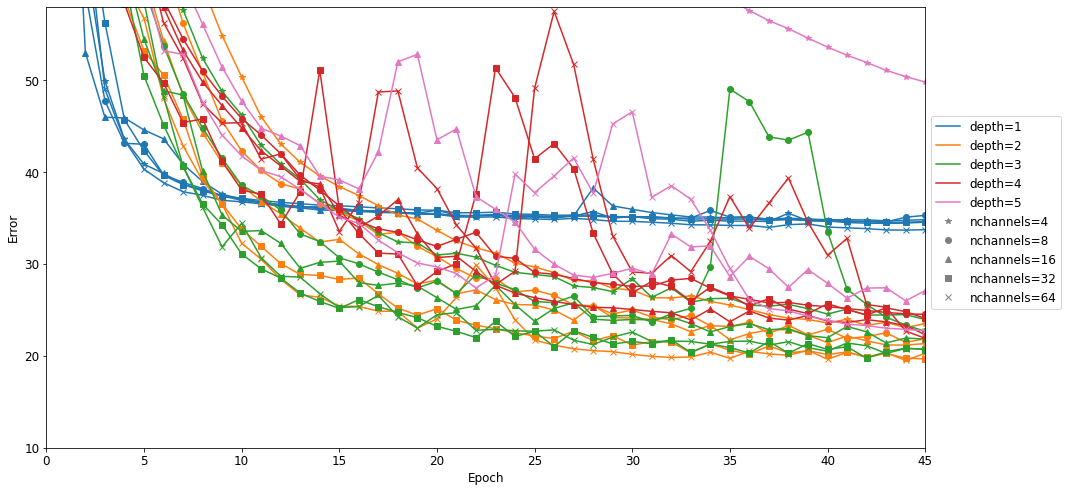

In [74]:
from matplotlib.lines import Line2D

all_losses = pickle.load(open('data_generated/report_figures/all_losses_depth_channels_reconstruction_comparison.pkl', 'rb'))

plt.figure(figsize=(15, 7))
styles = ['C'+str(c)+'-'+s for c in [0,1,2,3,6] for s in ['*','o','^','s','x']]
plt.ylim(10, 58)
plt.xlim(0, 45)

ys = [t[1] for t in all_losses.values()]
for y, s in zip(ys, styles):
    plt.plot(np.arange(1, num_epoch+1), y, s)
plt.xlabel('Epoch')
plt.ylabel('Error')

lines_color  = [Line2D([0], [0], linestyle='-', color='C'+str(c)) for c in [0,1,2,3,6]]
lines_marker = [Line2D([0], [0], linewidth=0, marker=s, color='gray') for s in ['*','o','^','s','x']]
labels = ['depth='+str(i) for i in range(1,6)] + ['nchannels='+str(i) for i in [4,8,16,32,64]]
plt.legend(lines_color+lines_marker, labels, bbox_to_anchor=(1., 0.3))
plt.tight_layout()
plt.savefig('data_generated/report_figures/reconstruction_error_comparison_tempconv_channels_depth_wrt_epoch.png', )

### Captured variance for PCA on videos

In [21]:
from sklearn.decomposition import PCA

vid1 = VideoLoader('data/JIGSAWS_converted/Suturing/video/Suturing_B001_capture1.avi', torch=False)
vid2 = VideoLoader('data/DET0101_V1_HI_Front.MOV', torch=False)
varcums = []
for video in [vid1, vid2]:
    nframes = 20*video.fps
    ratio = float(nframes)/video.total_frames

    random_frames = video.get_random_frames(ratio)
    pca = PCA().fit(random_frames.reshape(random_frames.shape[0], -1))
    varcums.append(np.cumsum(pca.explained_variance_ratio_))
pickle.dump(varcums, open('data_generated/report_figures/cumulative_variance_PCA.pkl', 'wb'))

Total variance explained at 10 components: 0.7563174
Total variance explained at 10 components: 0.8140908


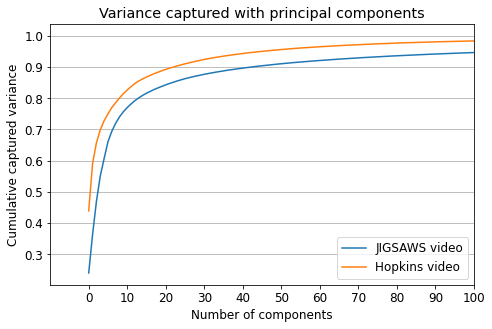

In [41]:
varcums = pickle.load(open('data_generated/report_figures/cumulative_variance_PCA.pkl', 'rb'))
std_size = (7, 4.5)
plt.figure(figsize=std_size)
plt.xlabel('Number of components')
plt.ylabel('Cumulative captured variance')
for varcum, label in zip(varcums, ['JIGSAWS video', 'Hopkins video']):
    plt.plot(varcum, label=label)
    plt.xlim(-10, 100)
    plt.tight_layout()
    plt.xticks(np.arange(0, 101, 10))
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.savefig('data_generated/report_figures/explained_variance_PCA.png')
_ = plt.title('Variance captured with principal components')

for varcum in varcums:
    print('Total variance explained at 10 components:', varcum[9])

Variance at 11: 0.011493206024169922
Variance at 11: 0.010777592658996582


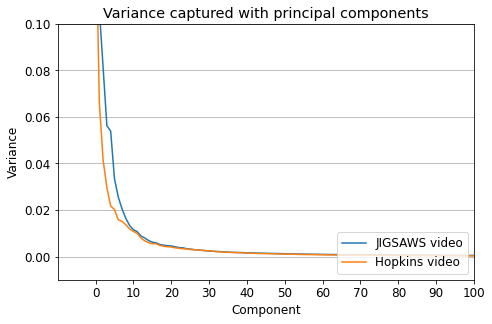

In [39]:
varcums = pickle.load(open('data_generated/report_figures/cumulative_variance_PCA.pkl', 'rb'))
std_size = (7, 4.5)
plt.figure(figsize=std_size)
plt.xlabel('Component')
plt.ylabel('Variance')
plt.ylim(-0.01,0.1)
variance_per_comp = []
for varcum in varcums:
    var = np.array(varcum)
    variance_per_comp.append(var[1:]-var[:-1])
for v, label in zip(variance_per_comp, ['JIGSAWS video', 'Hopkins video']):
    plt.plot(v, label=label)
    plt.xlim(-10, 100)
    plt.tight_layout()
    plt.xticks(np.arange(0, 101, 10))
plt.grid(axis='y')
plt.legend(loc='lower right')
#plt.savefig('data_generated/report_figures/variance_per_component_PCA.png')
_ = plt.title('Variance captured with principal components')

for v in variance_per_comp:
    print(f"Variance at 11: {v[10]}")